In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -R /content/drive/MyDrive/ITBA/reduced/* /content/data

In [238]:
from PIL import Image
import numpy as np
import albumentations as A


In [53]:
path = "/content/data/"

In [260]:
img1 = Image.open(path+"imgs/23_train_1_.png")
mask1 = Image.open(path+"gt/23_train_1_.png")

In [269]:
transform = A.Compose([
    A.RandomRotate90(),
    A.Transpose(),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
    A.Blur(blur_limit=3),
])

In [270]:
augmented_image = transform(
    image = np.array(img1.resize((256,256))).reshape(256,256,1),
    mask =  np.array(mask1.resize((256,256))).reshape(256,256,1))

In [271]:
augmented_image.keys()

dict_keys(['image', 'mask'])

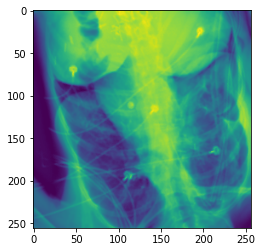

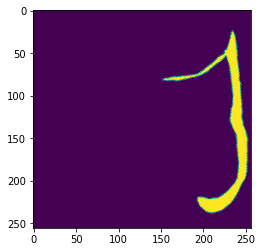

In [272]:
plt.imshow(augmented_image['image'].reshape(256,256))
plt.show()
plt.imshow(augmented_image['mask'].reshape(256,256))
plt.show()

In [299]:
import tensorflow as tf
 
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, path, img_prefix, mask_prefix, transform=False, batch_size=4, dim=(256,256), n_channels=1, shuffle=True):
        'Initialization'
        self.path = path
        self.transform = transform
        self.n_channels = n_channels
        self.img_prefix = img_prefix
        self.mask_prefix = mask_prefix
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.filenames = [file.name for file in Path(path).glob("imgs/*.png")]
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(filenames)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        np.random.shuffle(self.filenames)

    def __data_generation(self, filenames):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, filename in enumerate(filenames):
            img = Image.open(self.path + self.img_prefix + filename).resize(self.dim)
            mask = Image.open(self.path + self.mask_prefix + filename).resize(self.dim)
            img = np.array(img).reshape(*self.dim, self.n_channels)/255
            mask = np.array(mask).reshape(*self.dim, self.n_channels)/255
            if self.transform:
                trf = self.transform(image = img, mask = mask)
                X[i,...] = trf['image']
                y[i,...] = trf['mask']
            else:
                X[i,...] = img
                y[i,...] = mask
        return X,y

In [300]:
datagen = DataGenerator(
    path,
    "imgs/",
    "gt/",
    transform = transform,
    batch_size = 16   
)

In [301]:
datagen_val = DataGenerator(
    path,
    "imgs/",
    "gt/",
    transform = False,
    batch_size = 16   
)

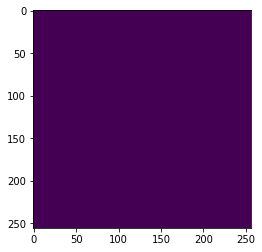

In [302]:
from matplotlib import pyplot as plt
plt.imshow(datagen[0][1][0].reshape(256,256))

In [303]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [304]:
def dice_coef(y_true, y_pred, smooth=0):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [305]:
model = Sequential()
model.add(Conv2D(20,30, input_shape = (227,227,1), activation="relu", padding="same"))
model.add(Conv2D(20,30, activation="relu", padding="same"))
model.add(Conv2D(20,30, activation="relu", padding="same"))
model.add(Conv2D(1,30, activation="sigmoid", padding="same"))
model.compile(loss=dice_coef_loss, optimizer=Adam(1e-4))


In [306]:
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [307]:
model = UNet((256,256,1),start_ch=32,depth=3,batchnorm=False, residual = True)


In [308]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_230 (Conv2D)            (None, 256, 256, 32  320         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_231 (Conv2D)            (None, 256, 256, 32  9248        ['conv2d_230[0][0]']             
                                )                                                           

In [309]:
model.compile(loss=dice_coef_loss, optimizer=Adam(1e-3))


In [ ]:
model.fit(datagen, epochs = 100, validation_data=datagen_val)

Epoch 1/100
4/4 [==============================] - 7s 2s/step - loss: 0.9807 - val_loss: 0.9821
Epoch 2/100
4/4 [==============================] - 5s 1s/step - loss: 0.9800 - val_loss: 0.9818
Epoch 3/100
4/4 [==============================] - 5s 1s/step - loss: 0.9807 - val_loss: 0.9814
Epoch 4/100
4/4 [==============================] - 5s 1s/step - loss: 0.9792 - val_loss: 0.9810
Epoch 5/100
4/4 [==============================] - 5s 1s/step - loss: 0.9784 - val_loss: 0.9804
Epoch 6/100
4/4 [==============================] - 5s 1s/step - loss: 0.9790 - val_loss: 0.9798
Epoch 7/100
4/4 [==============================] - 5s 1s/step - loss: 0.9824 - val_loss: 0.9809
Epoch 8/100
4/4 [==============================] - 5s 1s/step - loss: 0.9805 - val_loss: 0.9801
Epoch 9/100
4/4 [==============================] - 5s 1s/step - loss: 0.9781 - val_loss: 0.9776
Epoch 10/100
4/4 [==============================] - 5s 1s/step - loss: 0.9745 - val_loss: 0.9758
Epoch 11/100
4/4 [=====================

In [234]:
preds = model.predict(datagen)

4/4 [==============================] - 2s 431ms/step


In [235]:
preds.shape

(64, 256, 256, 1)

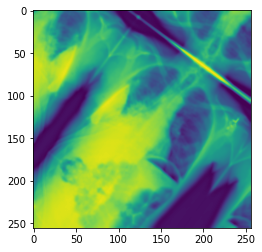

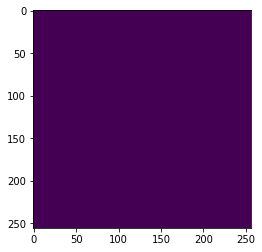

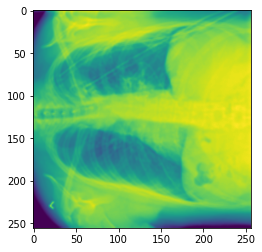

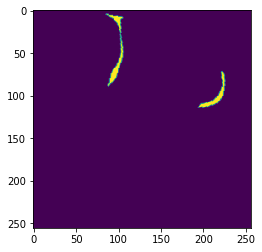

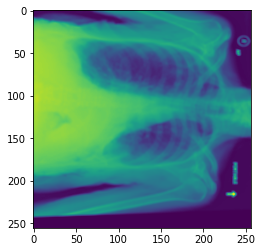

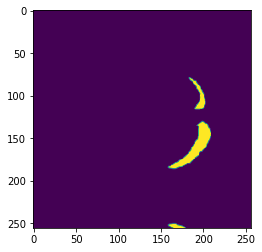

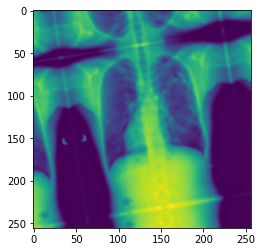

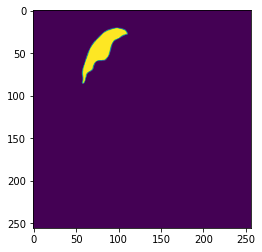

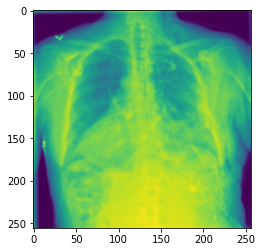

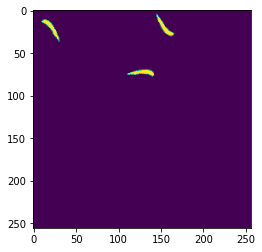

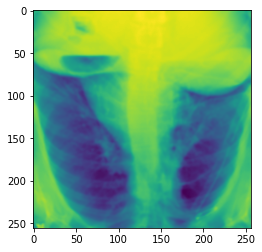

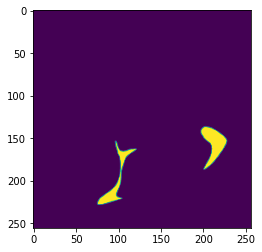

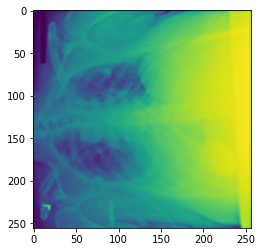

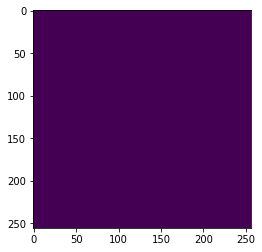

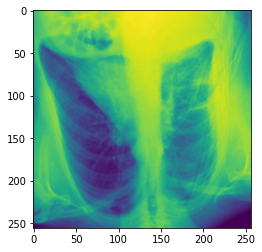

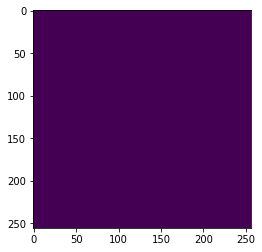

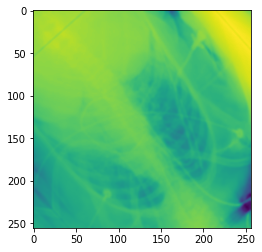

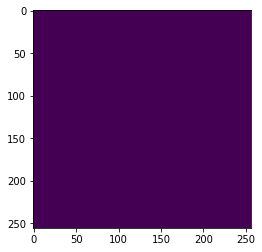

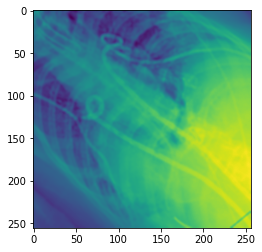

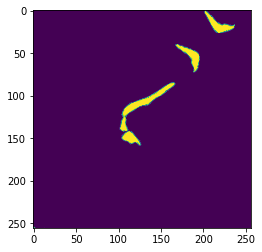

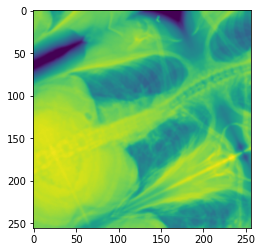

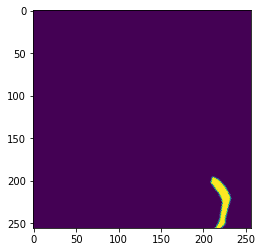

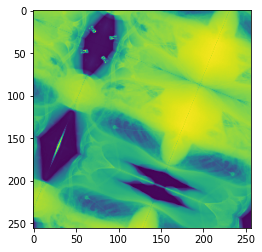

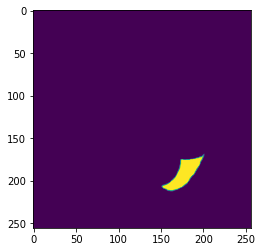

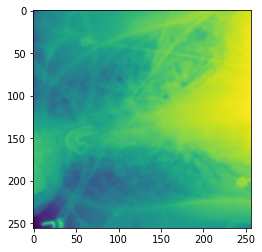

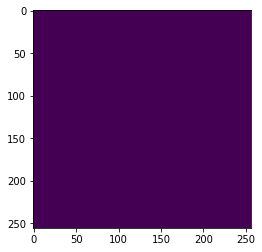

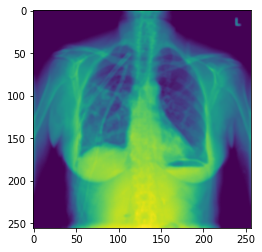

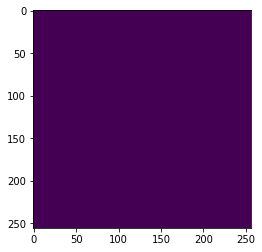

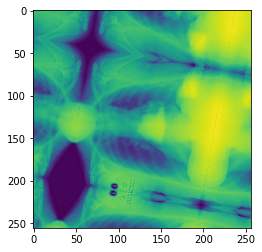

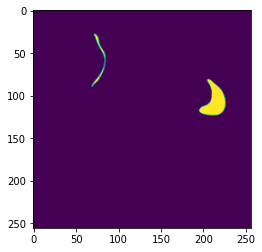

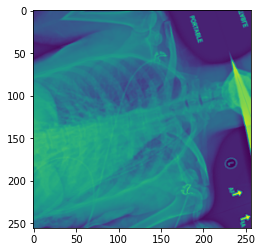

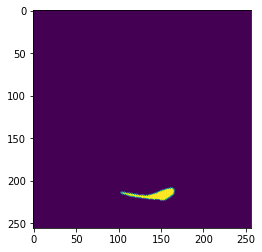

In [287]:
for idx in range(16):
    plt.imshow(datagen[0][0][idx].reshape(256,256))
    plt.show()
    plt.imshow(datagen[0][1][idx].reshape(256,256))
    plt.show()

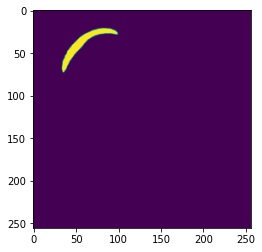

In [224]:
plt.imshow(datagen[0][1][2].reshape(256,256))

In [226]:
preds[2,...].sum()

0.043954875